In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Hiragino San' 

In [9]:
df_max["年月日"] = pd.to_datetime(df_max["年月日"])
df_max.groupby(df_max["年月日"].dt.year)["最高気温(℃)"].describe()

,count,mean,std,min,25%,50%,75%,max
年月日,,,,,,,,
2015,365.0,20.849315,7.882128,3.8,13.500,21.40,27.000,37.7
2016,366.0,20.908470,7.776269,5.0,14.325,21.40,27.275,37.7
2017,365.0,20.413425,7.986934,3.8,13.200,20.40,27.300,37.1
2018,365.0,21.251233,8.441937,3.8,14.400,21.80,27.600,39.0
2019,365.0,20.943014,7.983220,3.5,14.000,21.50,27.700,36.2
2020,366.0,21.050546,7.770632,6.5,14.400,20.65,27.200,37.3
2021,365.0,21.378356,7.434668,5.7,15.800,21.30,27.400,36.8
2022,365.0,21.141096,8.375324,2.6,13.700,20.90,27.800,37.0
2023,365.0,22.550959,8.400038,3.5,15.400,22.60,29.800,37.7


In [10]:
hot_2020 = df_max[(df_max["年月日"].dt.year == 2020) & (df_max["最高気温(℃)"] >= 35)]
print(hot_2020[["年月日", "最高気温(℃)"]].head(20))
print("件数:", len(hot_2020))


            年月日  最高気温(℃)
2045 2020-08-07     35.4
2048 2020-08-10     35.2
2049 2020-08-11     37.3
2050 2020-08-12     35.8
2051 2020-08-13     36.1
2053 2020-08-15     36.1
2054 2020-08-16     35.4
2055 2020-08-17     36.5
2059 2020-08-21     36.0
2060 2020-08-22     35.2
2067 2020-08-29     35.0
2073 2020-09-04     35.1
件数: 12


16:06:29 - cmdstanpy - INFO - Chain [1] start processing
16:06:29 - cmdstanpy - INFO - Chain [1] done processing


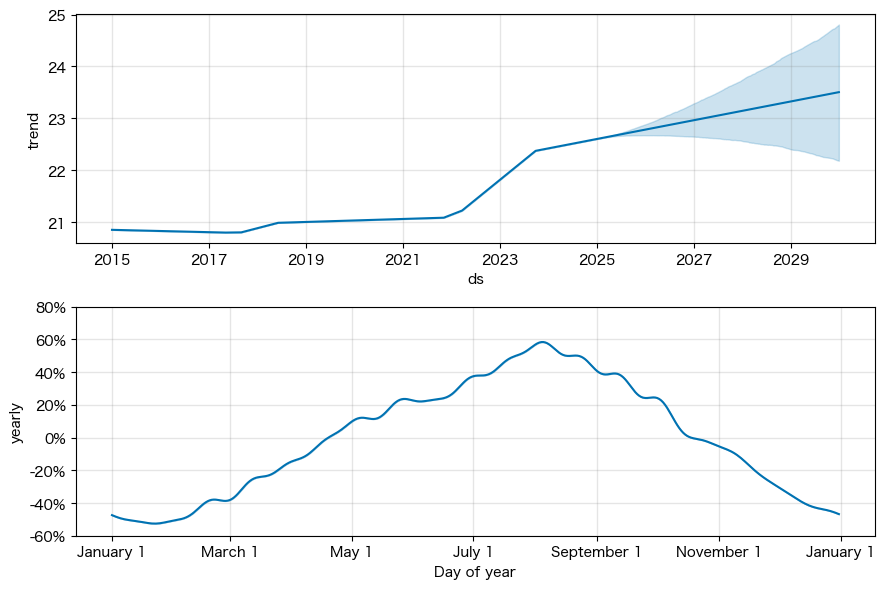

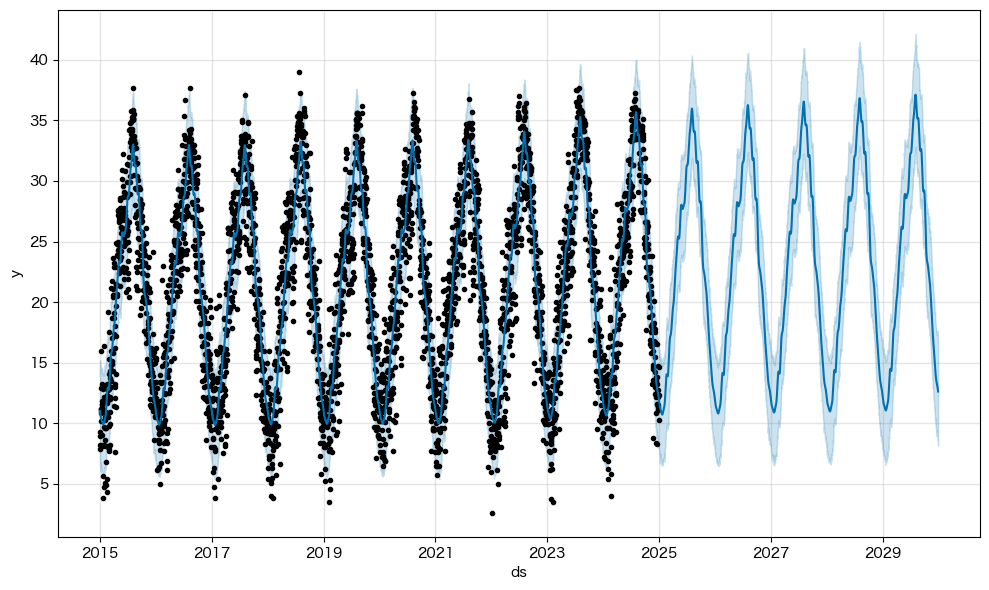

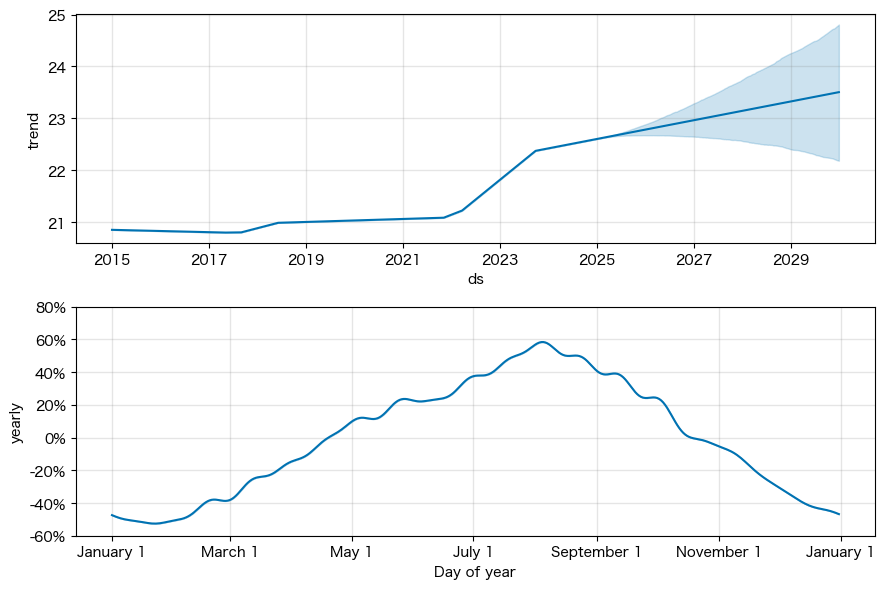

In [6]:
from prophet import Prophet

df_max = pd.read_csv("max_data.csv",skiprows=3)
df_max = df_max.iloc[:,[0,1]]
df_max = df_max.drop(index=0).reset_index(drop=True)
df_max = df_max.drop(index=0).reset_index(drop=True)

# Phrophet用に整形
df_prophet = df_max.rename(columns = {"年月日" : "ds", "最高気温(℃)" : "y"} )

# 日付型に変換
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])

# 学習
model = Prophet(changepoint_range=0.95,
                changepoint_prior_scale=0.1,
                seasonality_mode="multiplicative",
                yearly_seasonality=20,
                weekly_seasonality=False)
model.fit(df_prophet)


# 未来5年
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)

# プロット
model.plot(forecast)
model.plot_components(forecast)

In [19]:
# 実測(~2024)
df_max["year"] = df_max["年月日"].dt.year
actual = (df_max["最高気温(℃)"] >= 35).groupby(df_max["year"]).sum().reset_index()
actual.columns = ["year", "days"]

# 予測(2025~)
forecast["year"] = forecast["ds"].dt.year
pred = (forecast[(forecast["year"] >= 2025)]["yhat"] >= 35).groupby(forecast["year"]).sum().reset_index()
pred.columns = ["year", "days"]

annual = pd.concat([actual, pred], ignore_index=True)

In [21]:
annual

,year,days
0,2015,11
1,2016,3
2,2017,2
3,2018,12
4,2019,12
5,2020,12
6,2021,2
7,2022,16
8,2023,22
9,2024,20


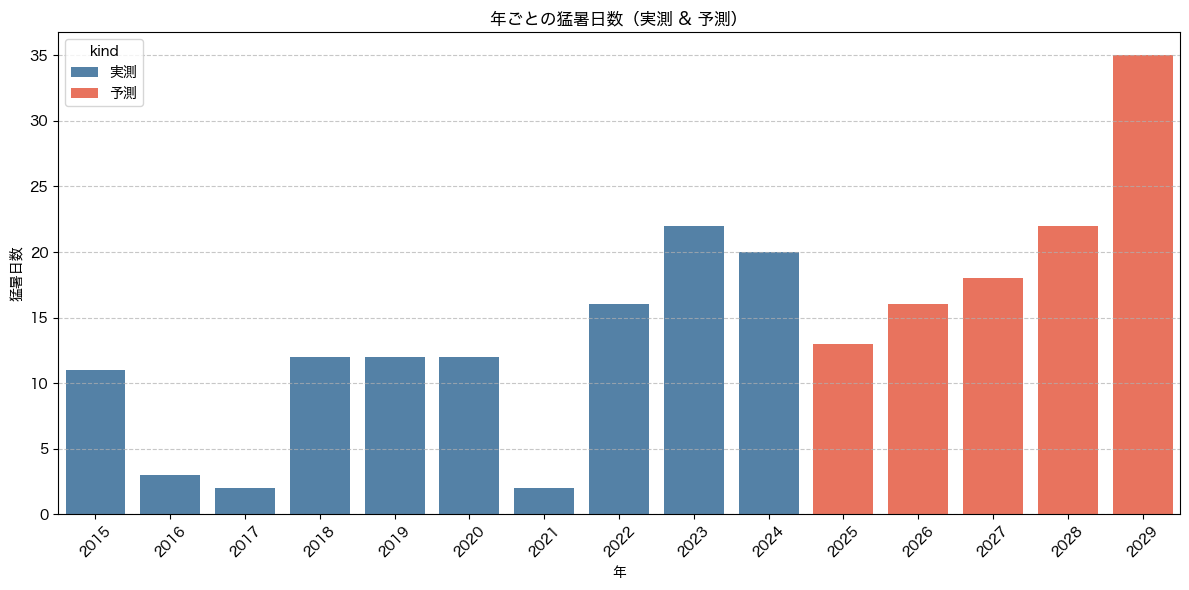

In [26]:
annual["kind"] = ["実測" if y <= 2024 else "予測" for y in annual["year"]]

plt.figure(figsize=(12,6))
sns.barplot(data=annual, x="year", y="days", hue="kind",palette={"実測":"steelblue","予測":"tomato"})

plt.xticks(rotation=45)
plt.xlabel("年")
plt.ylabel("猛暑日数")
plt.title("年ごとの猛暑日数（実測 & 予測）")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

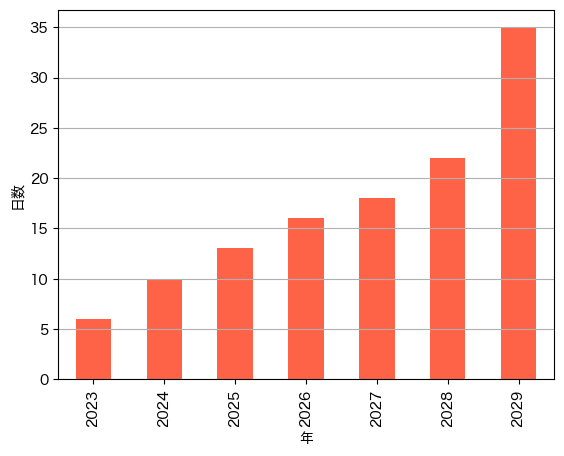

In [24]:
# 抽出
heatwave = forecast[forecast["yhat"] >= 35.0].copy()

# 年ごとの件数集計
heatwave["year"] = heatwave["ds"].dt.year
annual_counts = heatwave.groupby("year").size()


annual_counts.plot(kind="bar", color="tomato")
plt.ylabel("日数")
plt.xlabel("年")
plt.grid(True, axis="y")
plt.show()

In [71]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(model, initial="2000 days",period="180 days", horizon="365 days")
df_p = performance_metrics(df_cv)
print(df_p.head())

  0%|          | 0/8 [00:00<?, ?it/s]

19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:58 - cmdstanpy - INFO - Chain [1] start processing
19:01:58 - cmdstanpy - INFO - Chain [1] done processing
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing
19:02:00 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing


  horizon        mse      rmse       mae      mape     mdape     smape  \
0 37 days  10.522232  3.243799  2.538474  0.165480  0.104834  0.151195   
1 38 days  10.503287  3.240878  2.537117  0.164931  0.106057  0.150774   
2 39 days  10.498720  3.240173  2.526085  0.164871  0.104577  0.150326   
3 40 days  10.523215  3.243950  2.517622  0.165894  0.103161  0.150770   
4 41 days  10.519236  3.243337  2.512505  0.167158  0.099967  0.151504   

   coverage  
0  0.792808  
1  0.792808  
2  0.791096  
3  0.787671  
4  0.784247  


2025-08-26 16:38:00.421 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 16:38:00.457 
  command:

    streamlit run /Users/tasskkiu2/myproject/.venv/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-08-26 16:38:00.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 16:38:00.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 16:38:00.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 16:38:00.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 16:38:00.458 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-26 16:38:00.459 Threa

DeltaGenerator()

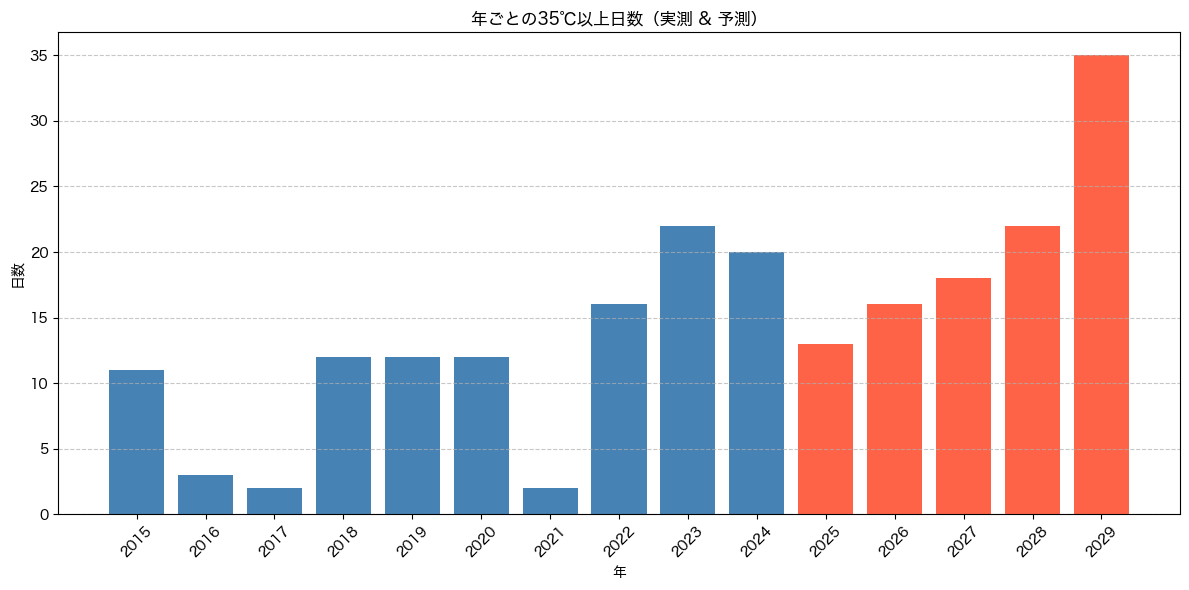

In [28]:
import streamlit as st
import pandas as pd

# ---- サイドバー ----
st.sidebar.header("設定")
thr = st.sidebar.slider("閾値（℃）", 25, 40, 35, step=1)

# 実測 (~2024)
df_max["year"] = df_max["年月日"].dt.year
actual = (df_max["最高気温(℃)"] >= thr).groupby(df_max["year"]).sum().reset_index()
actual.columns = ["year", "days"]

# 予測 (2025~)
forecast["year"] = forecast["ds"].dt.year
pred = (forecast[(forecast["year"] >= 2025)]["yhat"] >= thr).groupby(forecast["year"]).sum().reset_index()
pred.columns = ["year", "days"]

# 結合
annual = pd.concat([actual, pred], ignore_index=True)

# ---- 可視化 ----
import matplotlib.pyplot as plt

annual["kind"] = ["実測" if y <= 2024 else "予測" for y in annual["year"]]

plt.figure(figsize=(12,6))
colors = annual["kind"].map({"実測":"steelblue","予測":"tomato"})
plt.bar(annual["year"].astype(str), annual["days"], color=colors)

plt.xticks(rotation=45)
plt.xlabel("年")
plt.ylabel("日数")
plt.title(f"年ごとの{thr}℃以上日数（実測 & 予測）")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

st.pyplot(plt)
